In [114]:
from utils import TECGDataModule
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np
from GAN_Arch_details import CycleGAN_Unet_Generator

In [115]:
import pandas as pd

from app.ecg.ecg import EcgDataset

from torch_ecg.augmenters import BaselineWanderAugmenter
from app.ecg.ecg import EcgSignal

ptbxl_data = pd.read_csv(r'C:\Users\baev-\PycharmProjects\ecg-service\data\ptbxl\labels.csv', index_col=0)

ptbxl_data.info()

def get_file_paths(filename):
    filename_lr = filename.split('/')[-1].split('_')[0]
    return fr"C:\Users\baev-\PycharmProjects\ecg-service\data\ptbxl\npy_signals100\{filename_lr}.npy"


clean_tags = lambda x: [e.replace("'", "") for e in x[1:-1].split(', ')]
ptbxl_data["file_paths"] = ptbxl_data["filename_lr"].apply(get_file_paths)
ptbxl_data["superdiagnostic"] = ptbxl_data["superdiagnostic"].apply(clean_tags)
#ptbxl_data

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(ptbxl_data["superdiagnostic"].values)
mlb.classes_.tolist()

train_labels = mlb.transform(ptbxl_data["superdiagnostic"].tolist())
ptbxl_data[mlb.classes_.tolist()] = train_labels


valid_df = ptbxl_data[ptbxl_data['strat_fold'] == 9]
test_df = ptbxl_data[ptbxl_data['strat_fold'] == 10]

dataset = EcgDataset(ptbxl_data)
valid_dataset = EcgDataset(valid_df)
test_dataset = EcgDataset(test_df)


<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 15709.0 to 11744.0
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           21388 non-null  float64
 1   sex                           21388 non-null  int64  
 2   height                        6918 non-null   float64
 3   weight                        9366 non-null   float64
 4   nurse                         19949 non-null  float64
 5   site                          21372 non-null  float64
 6   device                        21388 non-null  object 
 7   recording_date                21388 non-null  object 
 8   report                        21388 non-null  object 
 9   scp_codes                     21388 non-null  object 
 10  heart_axis                    13228 non-null  object 
 11  infarction_stadium1           5600 non-null   object 
 12  infarction_stadium2           103 non-null    object 
 13

C:\Users\baev-\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-S8mQcxkY-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\baev-\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-S8mQcxkY-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\baev-\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-S8mQcxkY-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [116]:
def moving_med(x, w):
  armed=[]
  index=w//2
  it=0
  while it+w<len(x):
    if w%2:
      armed.append(sorted(x[it:it+w])[index])
    else:
      armed.append(sum(sorted(x[it:it+w])[index-1:index+1])/2)
    it+=1
  return armed

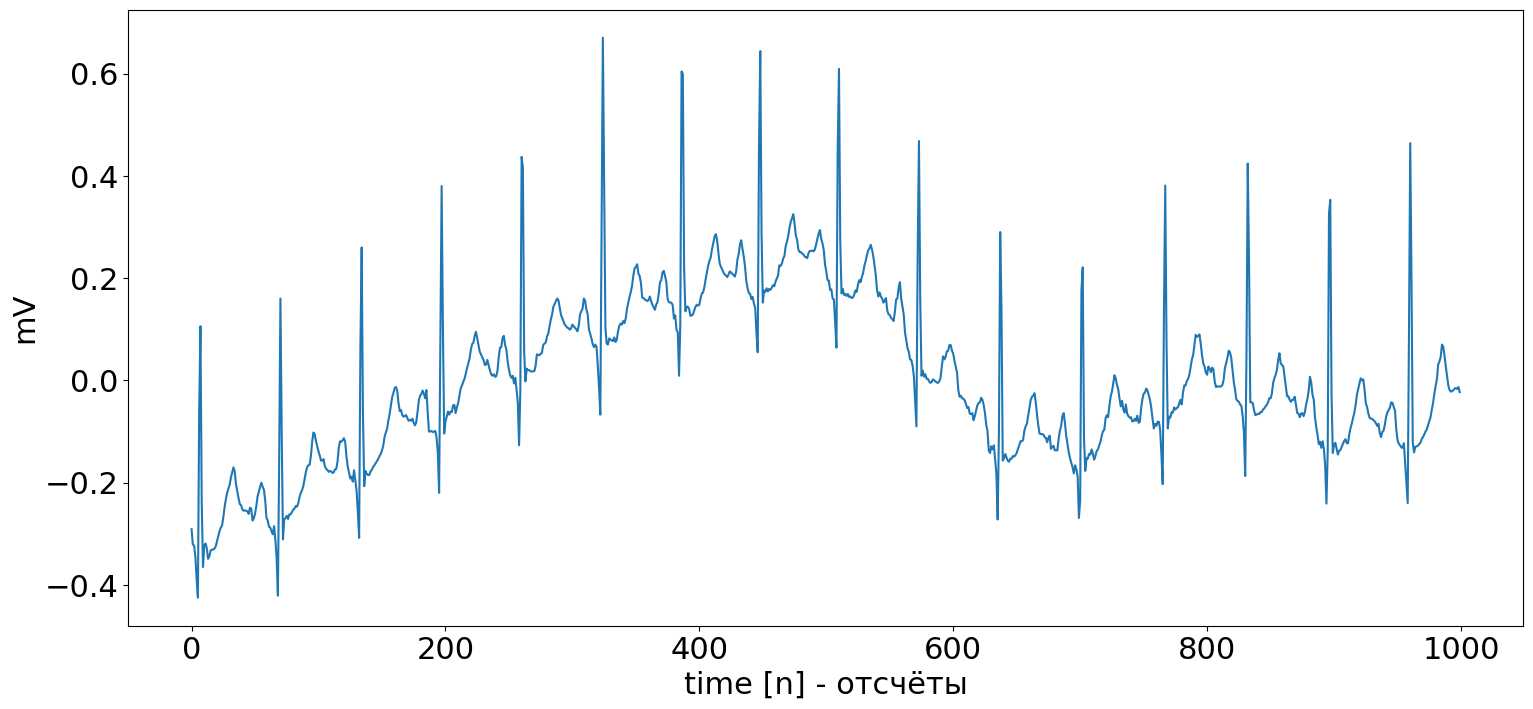

In [148]:

ecg, label = dataset[18055]
esig = EcgSignal()
esig.plot_sample(ecg[0][5])

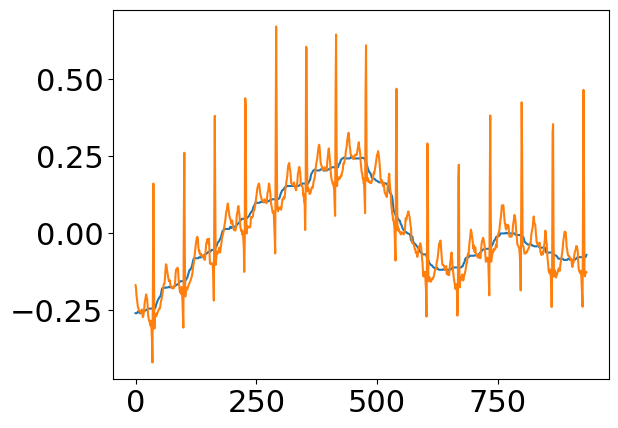

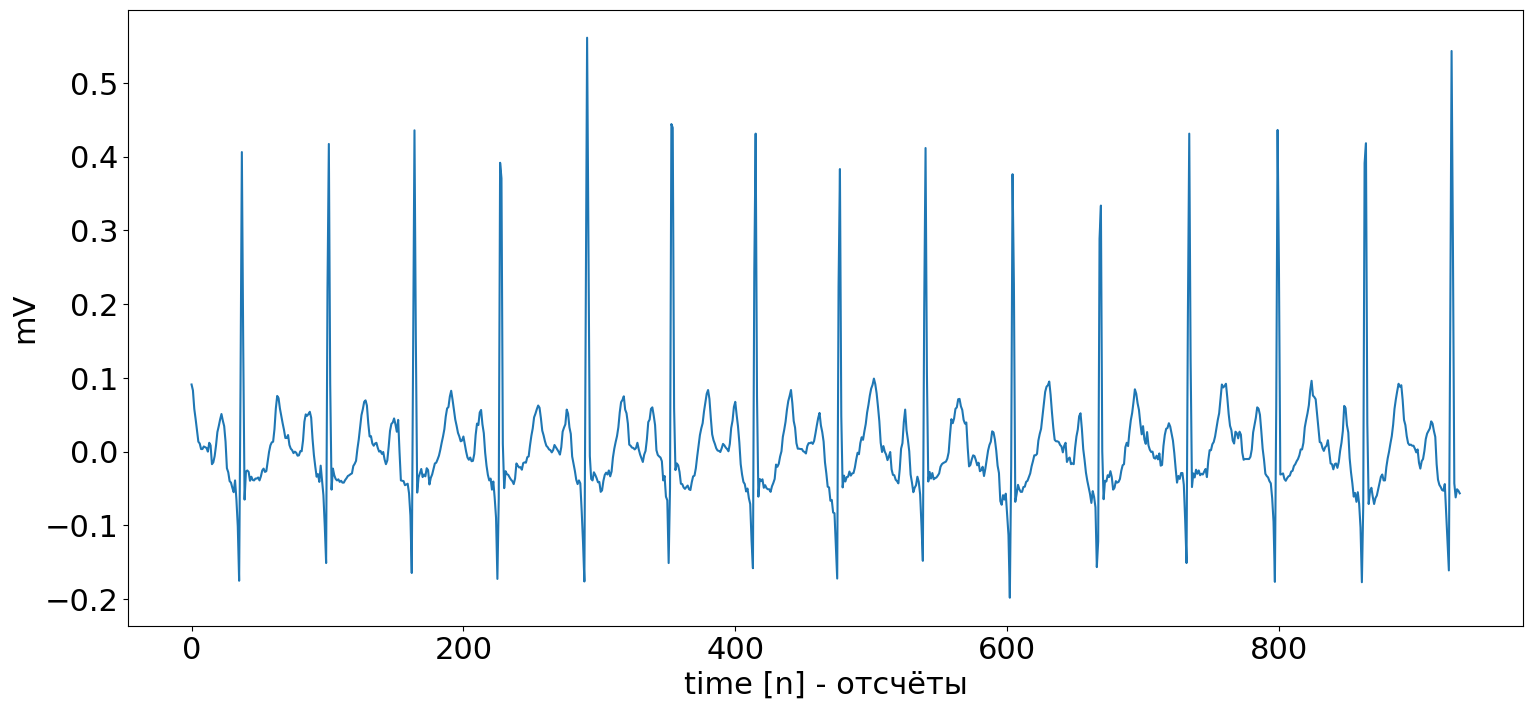

In [149]:
from matplotlib import pyplot as plt

mm=moving_med(np.array(ecg[0][5]),66)
plt.plot(mm)
plt.plot(ecg[0][5].detach().numpy()[33:1000-33])
esig.plot_sample(torch.from_numpy(ecg[0][5].detach().numpy()[33:1000-33]- mm))

In [150]:
#esig.plot_sampleplot_sample(ecg[0][5][33:1000-33] - mm)

(4000,)

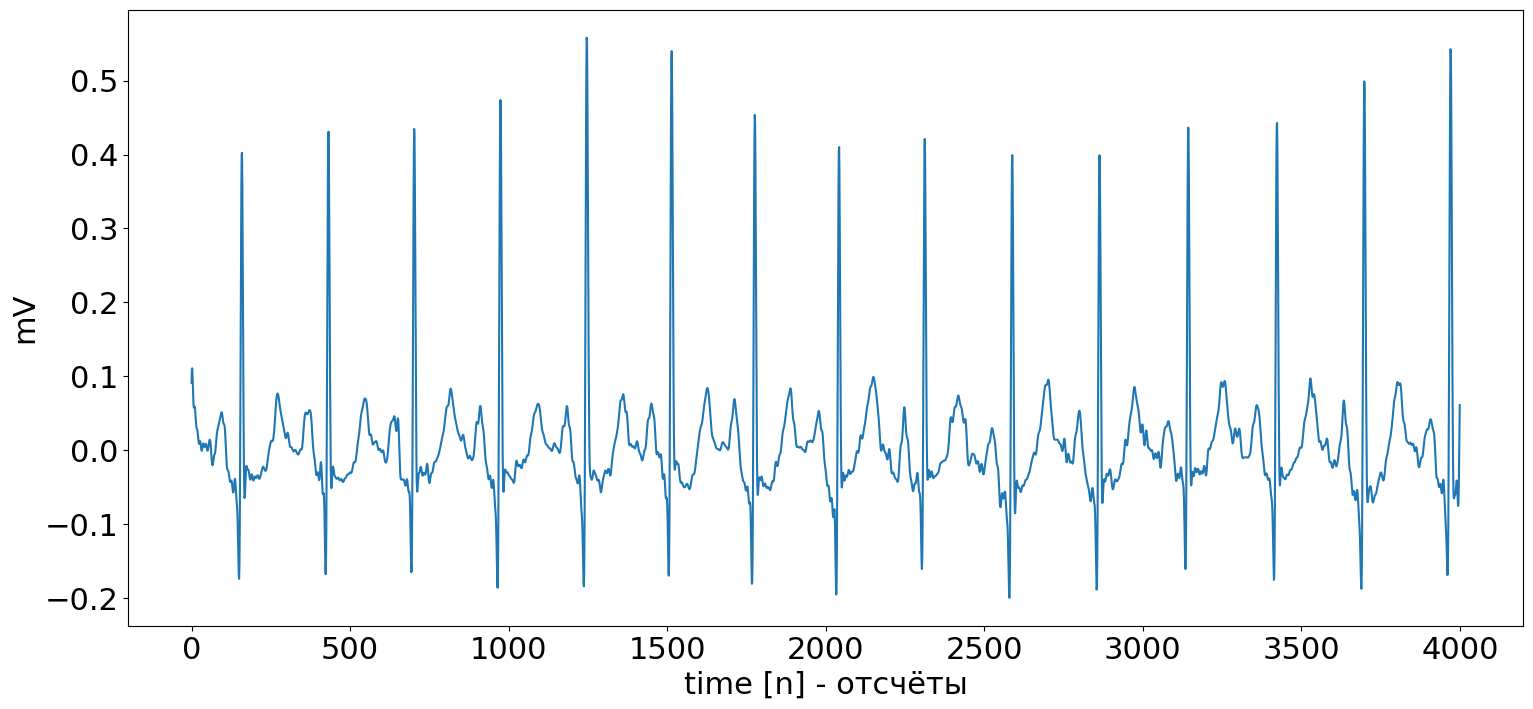

In [151]:
from scipy import signal


new_ecg = signal.resample(torch.from_numpy(ecg[0][5].detach().numpy()[33:1000-33]- mm), 4000)
esig.plot_sample(new_ecg)
new_ecg.shape

In [152]:
G_basestyle = CycleGAN_Unet_Generator()

checkpoint =torch.load("model_weights_16NQ3.pth")

G_basestyle.load_state_dict(checkpoint)

G_basestyle.eval()
G_basestyle.double()
 
#dm = TECGDataModule(data_dir, batch_size, phase='test')
#dm.prepare_data()
#dataloader = dm.train_dataloader()
#train_dat= torch.utils.data.TensorDataset(torch.tensor(test_data_x).to(device), torch.tensor(test_data_y).to(device))


base, style = torch.from_numpy(new_ecg[None,None,:]).to(torch.double), torch.from_numpy(new_ecg[None,None,:]).to(torch.double)
#base, style = torch.rand([8,1,4000]).to(torch.double), torch.rand([8,1,4000]).to(torch.double)
#print('Input Shape {}, {}'.format(base.size(), style.size())) 
#print(type(base))

net = G_basestyle
net.eval()
predicted = []
predicted=pd.DataFrame(data=predicted)
actual = []
actual=pd.DataFrame(data=actual)
output = net(net(base)).squeeze()

In [153]:
output.shape

torch.Size([4000])

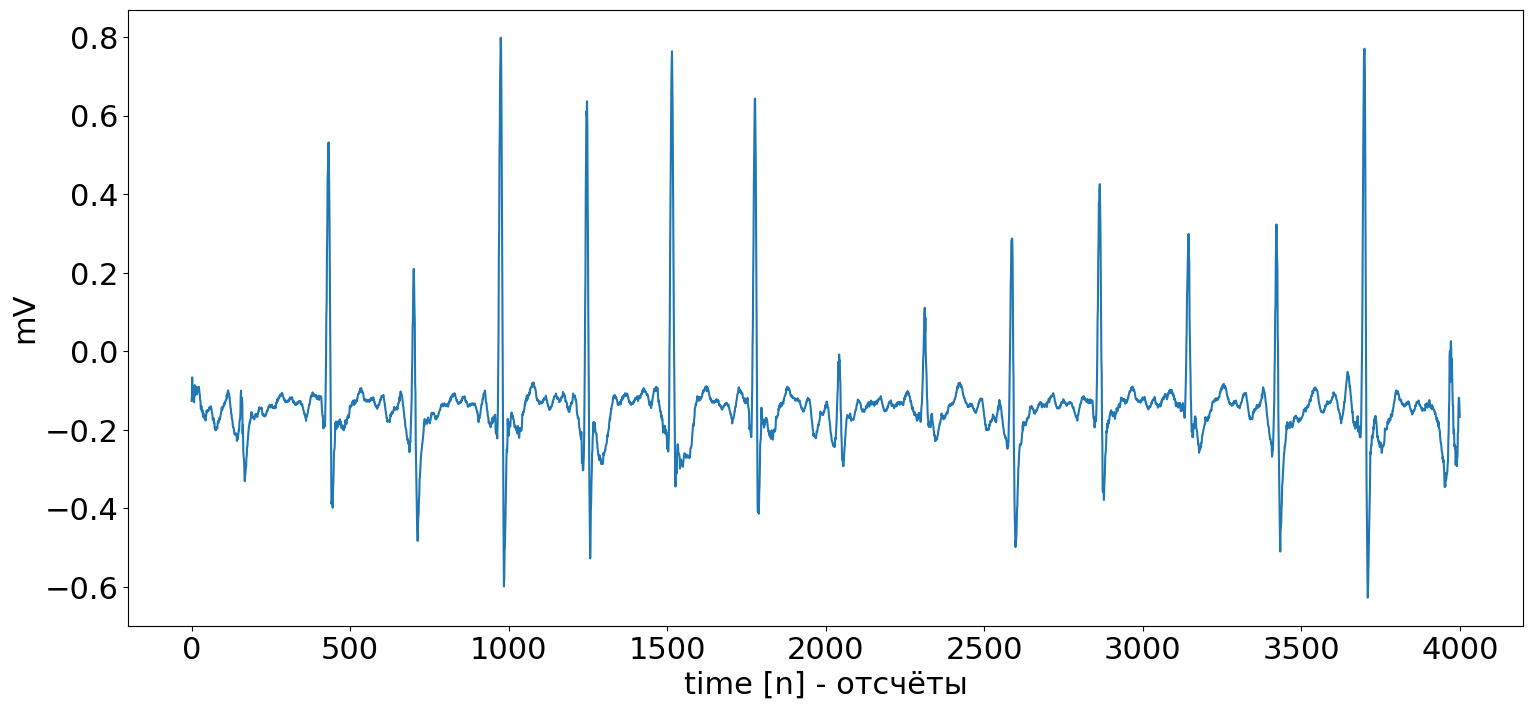

In [154]:
esig.plot_sample(output.detach().numpy())

In [155]:
ecg = np.load(r"C:\Users\baev-\PycharmProjects\ecg-service\data\ptbxl\npy_signals100\00001.npy")
ecg[0]

array([-0.119, -0.055,  0.064,  0.086, -0.091,  0.004, -0.069, -0.031,
        0.   , -0.026, -0.039, -0.079])

In [156]:
ecg.shape

(1000, 12)